In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders
import itertools
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Reading dataset

In [5]:
train=pd.read_csv(r'D:\Downloads\Insurance_Churn_ParticipantsData\Insurance_Churn_ParticipantsData\Train.csv')
test=pd.read_csv(r'D:\Downloads\Insurance_Churn_ParticipantsData\Insurance_Churn_ParticipantsData\Test.csv')

# EDA

In [6]:
train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,labels
0,-0.276515,-0.424429,1.344997,-0.012283,0.076230,1.076648,0.182198,3,0,1,0,0,0,0,10,2,1
1,0.853573,0.150991,0.503892,-0.979179,-0.569351,-0.411453,-0.251940,4,1,2,0,1,0,0,0,3,0
2,0.947747,-0.173832,1.825628,-0.703478,0.076230,-0.411453,-0.251940,6,1,2,0,0,0,0,5,3,0
3,0.853573,-0.381404,0.984523,-0.039464,-0.569351,-0.411453,-0.251940,4,0,2,0,1,0,0,5,3,0
4,1.324443,1.590527,-1.178318,-0.097711,-0.246560,-0.411453,-0.251940,0,1,1,0,0,0,0,8,3,0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33908 entries, 0 to 33907
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_0   33908 non-null  float64
 1   feature_1   33908 non-null  float64
 2   feature_2   33908 non-null  float64
 3   feature_3   33908 non-null  float64
 4   feature_4   33908 non-null  float64
 5   feature_5   33908 non-null  float64
 6   feature_6   33908 non-null  float64
 7   feature_7   33908 non-null  int64  
 8   feature_8   33908 non-null  int64  
 9   feature_9   33908 non-null  int64  
 10  feature_10  33908 non-null  int64  
 11  feature_11  33908 non-null  int64  
 12  feature_12  33908 non-null  int64  
 13  feature_13  33908 non-null  int64  
 14  feature_14  33908 non-null  int64  
 15  feature_15  33908 non-null  int64  
 16  labels      33908 non-null  int64  
dtypes: float64(7), int64(10)
memory usage: 4.4 MB


# Altering dtype of some features(7-15)
Might be these are categorical and pre-labelencoded.To generate some new feature from them i have again altered their dtype.

In [8]:
for col in train.columns:
    if train[col].dtype=='int64':
        train[col]=train[col].astype(str)

In [9]:
train.describe(exclude='number')

,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,labels
count,33908,33908,33908,33908,33908,33908,33908,33908,33908,33908
unique,12,3,4,2,2,2,3,12,4,2
top,1,1,1,0,1,0,0,8,3,0
freq,7286,20434,17380,33293,18836,28494,21978,10273,27756,29941


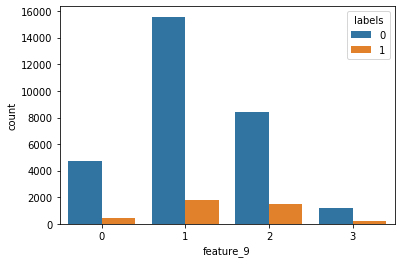

In [10]:
sns.countplot(x='feature_9',data=train,hue='labels')# do target encoding

train['sum']=train.feature_0+train.feature_1+train.feature_2+train.feature_3+train.feature_4+train.feature_5+train.feature_6
train['sum']=train['sum']**-1
sns.distplot(train.loc[train.labels=='1','sum'])
sns.distplot(train.loc[train.labels=='0','sum'])

In [11]:
train.labels.value_counts()

0    29941
1     3967
Name: labels, dtype: int64

### Extracting feature and label

In [12]:
label=train.copy().pop('labels')
feature=train.copy().iloc[:,:-1]

In [13]:
num_features=feature.describe().columns
num_features

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6'],
      dtype='object')

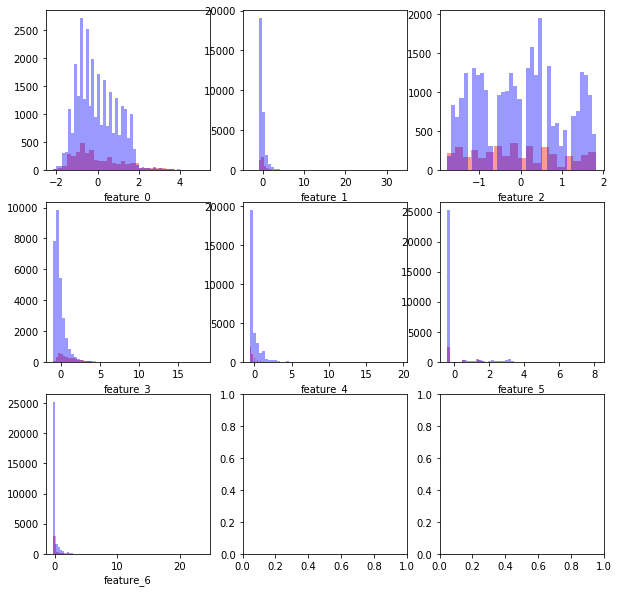

In [14]:
# Distribution of all the numerical features.
_,ax=plt.subplots(nrows=3,ncols=3,figsize=(10,10))
ax=ax.flatten()
for col,ax in zip(num_features,ax):
    sns.distplot(train.loc[train.labels=='1',col],color='r',ax=ax,kde=False)
    sns.distplot(train.loc[train.labels=='0',col],color='b',ax=ax,kde=False)

### New feature generation

In [16]:
#Based on the aggreagation of the numerical one-I
feature['sum']=feature.feature_0+feature.feature_1+feature.feature_2+feature.feature_3+feature.feature_4+feature.feature_5+feature.feature_6
feature['sum']=feature['sum']**-1

In [17]:
# Numerical combination -II
for col1,col2 in itertools.combinations(num_features,2):
    feature[col1+col2]=feature[col1]+feature[col2]

In [18]:
num_features_=feature.describe().columns
num_features_

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'sum', 'feature_0feature_1',
       'feature_0feature_2', 'feature_0feature_3', 'feature_0feature_4',
       'feature_0feature_5', 'feature_0feature_6', 'feature_1feature_2',
       'feature_1feature_3', 'feature_1feature_4', 'feature_1feature_5',
       'feature_1feature_6', 'feature_2feature_3', 'feature_2feature_4',
       'feature_2feature_5', 'feature_2feature_6', 'feature_3feature_4',
       'feature_3feature_5', 'feature_3feature_6', 'feature_4feature_5',
       'feature_4feature_6', 'feature_5feature_6'],
      dtype='object')

feature=feature.join(feature[num_features_].apply(lambda x:x**2).add_suffix('_2'))
feature=feature.join(feature[num_features_].apply(lambda x:x**.5).add_suffix('_.5'))

In [20]:
cat_features=feature.describe(exclude='number').columns

In [21]:
# Based on the categorical features.
for col1,col2 in itertools.combinations(cat_features,2):
    feature[col1+'_'+col2]=feature[col1]+feature[col2]
    
#for col1,col2,col3 in itertools.combinations(cat_features,3):
    #feature[col1+'_'+col2+col3]=feature[col1]+feature[col2]+feature[col3]  

In [22]:
cat_features_=feature.describe(exclude='number').columns
cat_features_

Index(['feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11',
       'feature_12', 'feature_13', 'feature_14', 'feature_15',
       'feature_7_feature_8', 'feature_7_feature_9', 'feature_7_feature_10',
       'feature_7_feature_11', 'feature_7_feature_12', 'feature_7_feature_13',
       'feature_7_feature_14', 'feature_7_feature_15', 'feature_8_feature_9',
       'feature_8_feature_10', 'feature_8_feature_11', 'feature_8_feature_12',
       'feature_8_feature_13', 'feature_8_feature_14', 'feature_8_feature_15',
       'feature_9_feature_10', 'feature_9_feature_11', 'feature_9_feature_12',
       'feature_9_feature_13', 'feature_9_feature_14', 'feature_9_feature_15',
       'feature_10_feature_11', 'feature_10_feature_12',
       'feature_10_feature_13', 'feature_10_feature_14',
       'feature_10_feature_15', 'feature_11_feature_12',
       'feature_11_feature_13', 'feature_11_feature_14',
       'feature_11_feature_15', 'feature_12_feature_13',
       'feature_12_feature_1

### Encoding

In [23]:
te=category_encoders.TargetEncoder()
te.fit(feature[cat_features_],label.map(int))
encoded=te.transform(feature[cat_features_])

In [24]:
feature.shape

(33908, 74)

In [25]:
feature=feature.join(encoded.add_suffix('_c'))

In [26]:
# Label Encoding
feature[cat_features_]=feature[cat_features_].apply(lambda x:x.map(int))

In [27]:
feature.shape

(33908, 119)

# Upsampling

In [28]:
from imblearn.over_sampling import SMOTE
sm=SMOTE(sampling_strategy='minority')
feature_,label_=sm.fit_sample(feature,label)

In [29]:
label_.value_counts()

1    29941
0    29941
Name: labels, dtype: int64

feature=feature_
label=label_

# test prepro

In [30]:
# On numerical attributes.
test['sum']=test.feature_0+test.feature_1+test.feature_2+test.feature_3+test.feature_4+test.feature_5+test.feature_6
test['sum']=test['sum']**-1
for col1,col2 in itertools.combinations(num_features,2):
    test[col1+col2]=test[col1]+test[col2]


for col in test.columns:
    if test[col].dtype=='int64':
        test[col]=test[col].astype(str)        

In [31]:
# On categorical attributes.        
for col1,col2 in itertools.combinations(cat_features,2):
    test[col1+'_'+col2]=test[col1]+test[col2]
    
encoded=te.transform(test[cat_features_])  
test=test.join(encoded.add_suffix('_c'))
test[cat_features_]=test[cat_features_].apply(lambda x:x.map(int))

In [32]:
test.shape

(11303, 119)

# Baseline models

In [58]:
X_train,X_test,y_train,y_test=train_test_split(feature_,label_,stratify=label_,random_state=9)
lgb=LGBMClassifier().fit(X_train,y_train)
y_pred=lgb.predict(X_test)

In [59]:
confusion_matrix(y_test,y_pred),f1_score(y_test,y_pred,pos_label='1')

(array([[7009,  477],
        [ 390, 7095]], dtype=int64),
 0.9424188085275951)

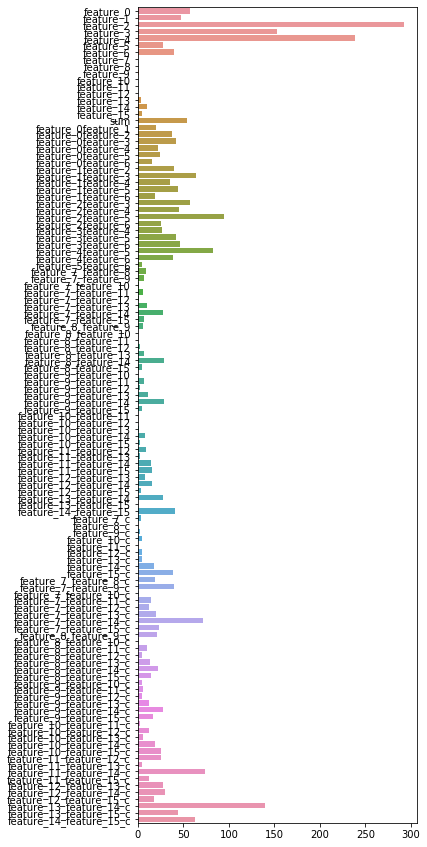

In [60]:
plt.figure(figsize=(5,15))
sns.barplot(y=X_train.columns,x=lgb.feature_importances_)

# Final

In [61]:
rf=RandomForestClassifier(max_depth=15)
knn=KNeighborsClassifier(n_neighbors=3)
xgb=XGBClassifier()
esti=(['lgb',lgb],['xgb',xgb],['knn',knn])
model=VotingClassifier(estimators=esti,n_jobs=-1).fit(X_train,y_train)
y_pred=model.predict(X_test)

In [62]:
confusion_matrix(y_test,y_pred),f1_score(y_test,y_pred,pos_label='1')

(array([[6889,  597],
        [ 272, 7213]], dtype=int64),
 0.9431840470742073)

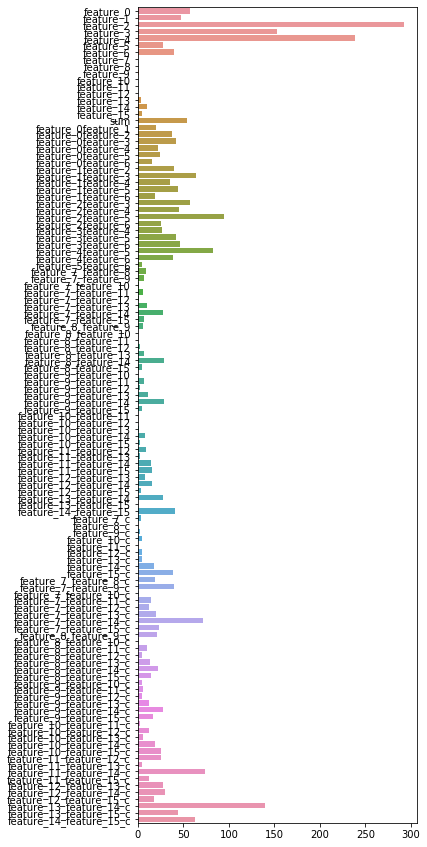

In [63]:
plt.figure(figsize=(5,15))
sns.barplot(y=X_train.columns,x=lgb.feature_importances_)

# Feature selection

#### By tree mothod

In [42]:
from sklearn.feature_selection import RFE
rfe=RFE(estimator=lgb,n_features_to_select=30,step=5).fit(feature_,label_)

In [43]:
selected_col=feature.columns[rfe.support_]
selected_col

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'sum',
       'feature_0feature_3', 'feature_0feature_4', 'feature_1feature_3',
       'feature_2feature_3', 'feature_2feature_4', 'feature_2feature_5',
       'feature_3feature_5', 'feature_3feature_6', 'feature_4feature_5',
       'feature_4feature_6', 'feature_9_feature_14', 'feature_13_feature_14',
       'feature_14_feature_15', 'feature_15_c', 'feature_7_feature_9_c',
       'feature_7_feature_14_c', 'feature_8_feature_14_c',
       'feature_11_feature_12_c', 'feature_11_feature_14_c',
       'feature_12_feature_13_c', 'feature_12_feature_14_c',
       'feature_13_feature_14_c', 'feature_13_feature_15_c',
       'feature_14_feature_15_c'],
      dtype='object')

#### By l1 regularization.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
lr=LogisticRegression(penalty='l1',C=.001,solver='saga').fit(feature_,label_)
model_=SelectFromModel(estimator=lr,prefit=True)
x_new=model_.transform(feature_)

C:\Users\pankaj\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [45]:
new=pd.DataFrame(model_.inverse_transform(x_new),index=feature_.index,columns=feature_.columns)

In [46]:
selected_col2=feature.columns[new.var()!=0]

In [47]:
selected_col2

Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'sum', 'feature_0feature_1', 'feature_0feature_3',
       'feature_0feature_4', 'feature_0feature_5', 'feature_0feature_6',
       'feature_1feature_3', 'feature_1feature_4', 'feature_1feature_5',
       'feature_1feature_6', 'feature_2feature_3', 'feature_2feature_4',
       'feature_2feature_5', 'feature_3feature_4', 'feature_3feature_5',
       'feature_3feature_6', 'feature_5feature_6', 'feature_7_feature_8',
       'feature_7_feature_9', 'feature_7_feature_10', 'feature_7_feature_11',
       'feature_7_feature_13', 'feature_7_feature_14', 'feature_7_feature_15',
       'feature_8_feature_9', 'feature_8_feature_10', 'feature_8_feature_11',
       'feature_8_feature_12', 'feature_8_feature_13', 'feature_8_feature_14',
       'feature_8_feature_15', 'feature_9_feature_10', 'feature_9_feature_11',
       'feature_9_fea

In [48]:
feature.shape

(33908, 119)

# Tunning

In [149]:
#pram={'num_leaves':(40,30,35),'max_depth':(15,20,30),'n_estimators':(200,300),'subsample_for_bin':(40000,80000),'subsample':(.8,.6)}
pram={'max_depth':(5,10,15),'n_estimators':(200,300)}
gs=GridSearchCV(estimator=XGBClassifier(),param_grid=pram,cv=2,n_jobs=-1).fit(np.array(X_train),y_train)


In [150]:
gs.best_params_

{'max_depth': 10, 'n_estimators': 300}

# Final model(Voting) on selected attributes by RFE

In [56]:
model.fit(feature_[selected_col],label_)

VotingClassifier(estimators=(['lgb',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=None, reg_alpha=0.0,
                                             reg_lambda=0.0, silent=True,
                                             subsam...
                                            n_jobs=1, nthr

In [163]:
y_pred=model.predict(test[selected_col])

In [164]:
pd.Series(y_pred,name='labels').to_csv(r'C:\Users\pankaj\Desktop\churn.csv',index=False)

In [165]:
pd.Series(y_pred).value_counts()

0    9551
1    1752
dtype: int64

# What i learned.